# Aula 22 - Clustering

![image.png](https://somostera.com/_nuxt/img/7eecdb7.svg)

## Warm Up

![image.png](https://media.giphy.com/media/l0Ex47BWhZ7bsaKcg/giphy.gif)

## Expectativas!

O que vocês esperam da aula de hoje?

![image.png](https://img.buzzfeed.com/buzzfeed-static/static/enhanced/web04/2012/2/14/17/enhanced-buzz-8358-1329258536-95.jpg?downsize=800:*&output-format=auto&output-quality=auto)

Objetivos gerais de algoritmos de clustering:
- Análise exploratória dos dados
- Encontrar padrões e estruturas
- Agrupar dados de forma a criar representações sumarizadas (sumarização de dados)

![](../figures/tipoAprendizado.png)

### Exemplo Inicial
Análise exploratória do comportamento dos usuários.

Dataset:
- `tempo` (float): Tempo em segundos que um usuário permanece no site.
- `ticket` (float): Valor gasto em reais no site.

In [10]:
#-- imports usados no curso
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [11]:
#-- leitura dos dados
df = pd.read_csv('../data/user_patterns.csv', sep=';', decimal='.')
df.head()

,tempo,ticket
0,138.492732,63.029202
1,306.160891,75.160275
2,264.210040,74.064756
3,326.972183,95.059350
4,268.796360,47.015198


#### Análise Exploratória

In [13]:
#-- valor médio
user_mean = df.mean().values
user_mean

array([718.41305716,  95.82494287])

In [14]:
#-- covariância
user_cov = np.cov(df.values[:,0], df.values[:,1])
user_cov

array([[123372.18378516,   6828.07629486],
       [  6828.07629486,   1709.87352627]])

In [15]:
#-- tendência - regressão
a, b, r, p, std_err = ss.linregress(df.values[:,0], df.values[:,1])
f = lambda x: a*x + b

In [16]:
#--printando o coeficiente de correlação da regressão
print('- Coeficiente de correlação da regressão: {:.2f}'.format(r))

- Coeficiente de correlação da regressão: 0.47


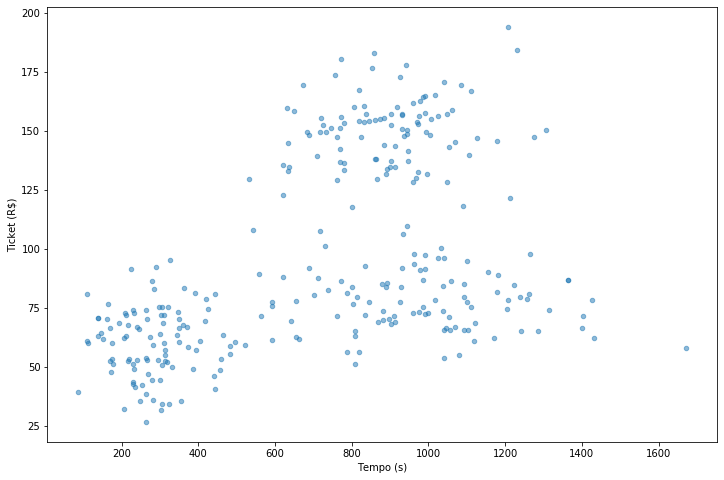

In [17]:
#-- vamos plotar o gráfico
df.plot.scatter(x='tempo',y='ticket', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Ticket (R$)')
plt.show()

In [18]:
### Função auxiliar para plotar a elipse de confiança ###
from matplotlib.patches import Ellipse

def get_confidence_ellipse(x, y, nstd=2):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='red', 
                  fill=False)
    return ell

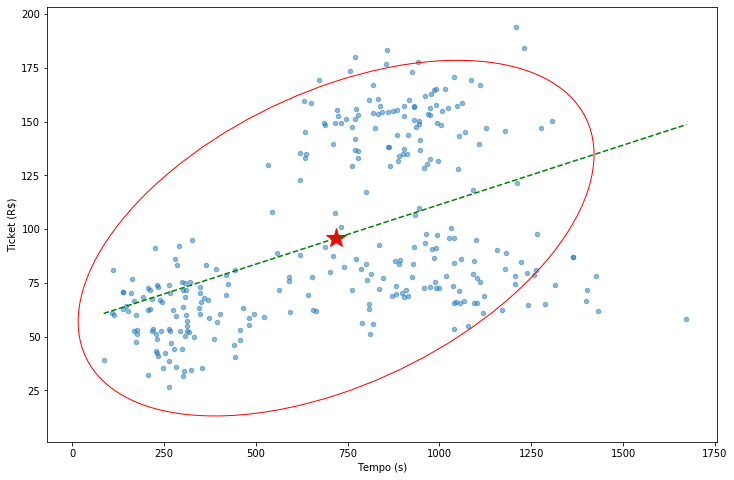

In [19]:
#-- vamos plotar os dados no gráfico
df.plot.scatter(x='tempo',y='ticket', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Ticket (R$)')

# Média
plt.plot(user_mean[0], user_mean[1], '*r', markersize=20)

# 2 desvios padrão
ell = get_confidence_ellipse(x=df.values[:,0],
                             y=df.values[:,1])
ax = plt.gca()
ax.add_patch(ell)

# Tendência
x = np.array([min(df.values[:,0]),max(df.values[:,0])])
plt.plot(x, f(x), '--g')

plt.show()

Há algo estranho nessa análise?


- A análise está matematicamente correta, mas talvez não seja completa;
- Precisamos levar em consideração possíveis grupos diferentes de usuários dentro dos dados. Quantos grupos você vê? Talvez entre 2 e 4 clusters?

Vamos utilizar o famoso algoritmo [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) para encontrar esses clusters. Podemos utilizar a implementação do [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) para isso.

---
## K-Means

<tr>
    <td> <img src="../figures/fluxogramaKmeans.png" style="width: 850px;" /> </td>
    <td> <img src="https://media.giphy.com/media/VryvUKuOxNLqM/giphy.gif" /> </td>
</tr>

In [20]:
#-- importe o módulo do KMeans
from sklearn.cluster import KMeans

# Crie uma instância do K-Means pelo sklearn
# Teste diferentes números de clusters
n = 3
kmeans = KMeans(n_clusters=n)

Agora podemos encontrar os clusters.

In [21]:
#-- aplicando o kmenas nos dados
kmeans.fit(df.values)
labels = kmeans.labels_

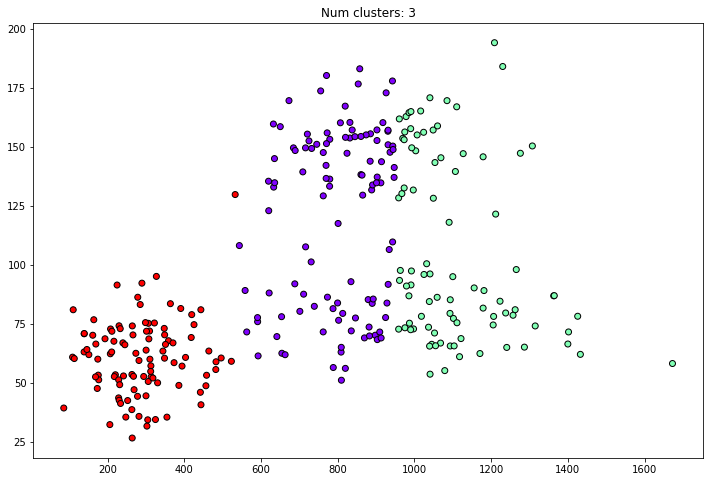

In [22]:
#-- plotando um gráficos com os clusters
plt.scatter(x=df.values[:,0],
            y=df.values[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(n))
plt.show()

Os clusters estão como esperado?

Devemos **padronizar** os dados!

In [23]:
#-- vamos padronizar os dados!
from sklearn.preprocessing import StandardScaler

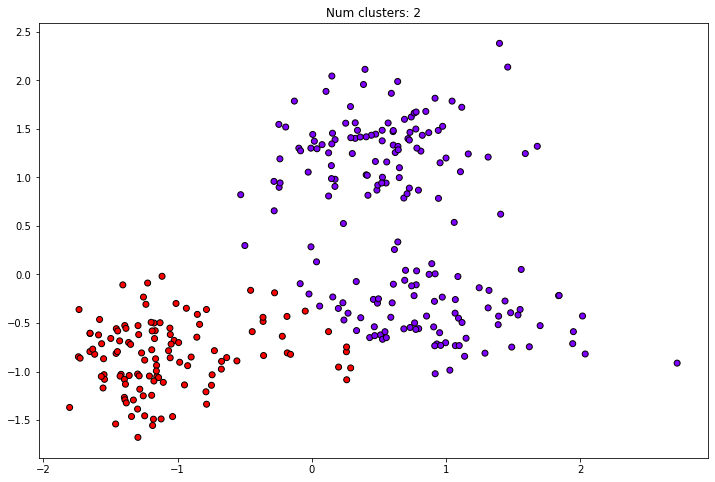

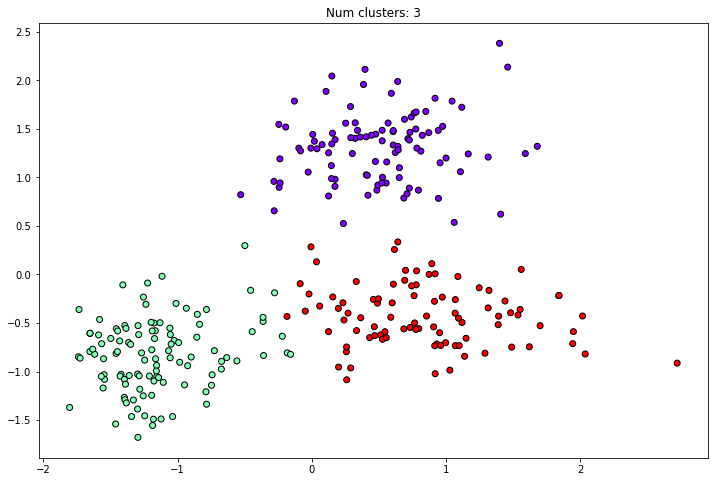

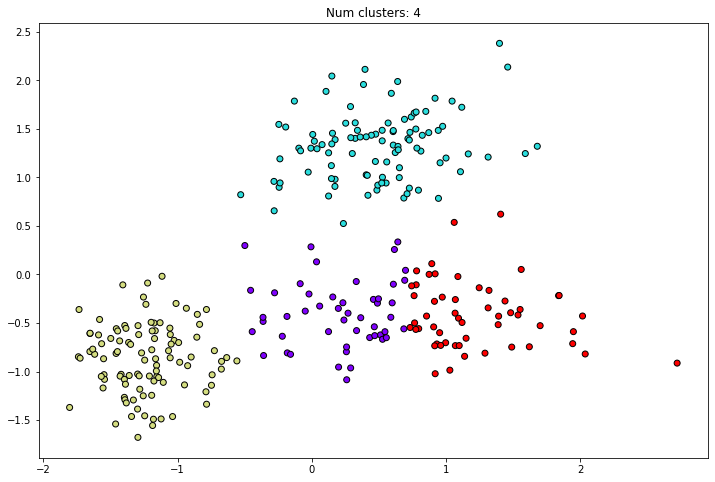

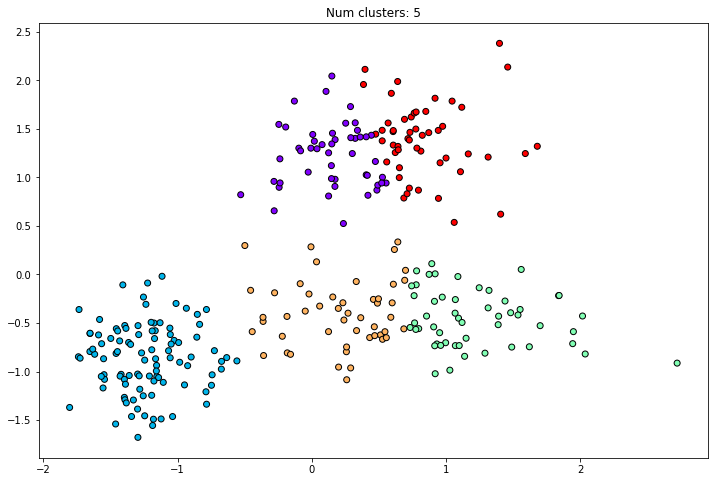

In [24]:
#-- e agora plotamos o resultado
n_clusters = range(2,6)

X = df.values

#-- dados padronizados
X_scaled = StandardScaler().fit_transform(X)

for n in n_clusters:
    estimator = KMeans(n_clusters=n, random_state=170)
    estimator.fit(X_scaled)
    labels = estimator.labels_
    plt.scatter(x=X_scaled[:,0],
                y=X_scaled[:,1],
                c=labels.astype(np.float),
                cmap='rainbow',
                edgecolor='k')
    plt.title('Num clusters: {}'.format(n))
    plt.show()

Ok... podemos ver que podemos encontrar algumas opções de número de clusters, mas qual é o valor ideal?

<tr>
    <td> <img src="https://media.giphy.com/media/13NUOwOLq0NJug/giphy.gif" /> </td>
</tr>

## Avaliação dos clusters

Como os dados não são rotulados, não podemos usar métricas de avaliação utilizadas em problemas de classificação como uma matriz de confusão, por exemplo.

Para problemas de agrupamento, existem diversas métricas possíveis para avaliar o quão bons foram os agrupamentos encontrados. Hoje falaremos sobre uma delas: o *Elbow method*.

- Alguns outros métodos: [artigo](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method)

**Elbow method ("método do cotovelo")**

Esse método nos fornece uma ideia de qual seria um bom número de clusters baseando-se na inércia entre os objetos e os centroides dos seus respectivos clusters. 

*Mas o que é essa "inércia"?*

A **inércia** é uma medida calculada ao rodarmos o K-means e ela se baseia na soma das distâncias quadráticas de cada objeto para os centroides de seus respectivos clusters. Portanto, quanto maior for a inércia, maior será a dispersão dos clusters; quanto menor, mais os clusters estarão compactados.

\begin{equation*}
Inércia (k) = \sum_{j=1}^{k}{\sum_{x_i \in cluster j}{||x_i - \bar{x_j}||^2}},
\quad \text{onde } \bar{x_j} \text{ é o centroide do cluster j}.
\end{equation*}

![](../figures/inercia.png)

Para escolhermos o número de clusters, observamos o gráfico do cotovelo com as inércias e escolhemos o ponto no qual a inércia começa a ficar mais plana e formar um "cotovelo":

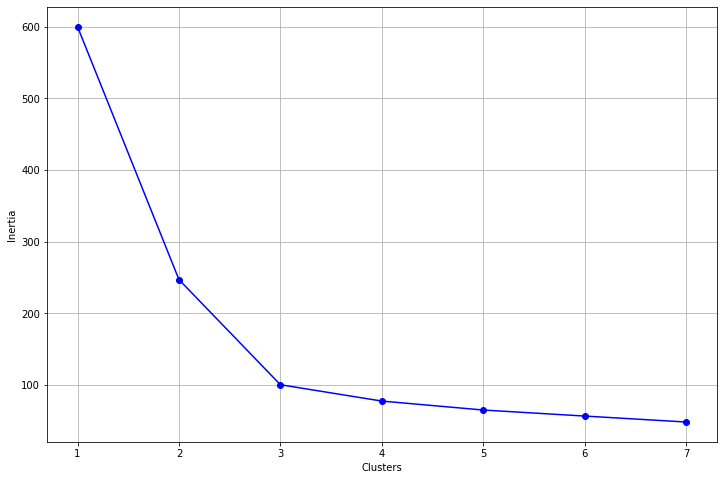

In [25]:
#-- range de valores de clusters que vamos testar
k = range(1,8,1)

#-- lista de inércias
inertias = []

#-- para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X_scaled)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Qual a sua opinião? Quantos clusters devemos utilizar? (3??)

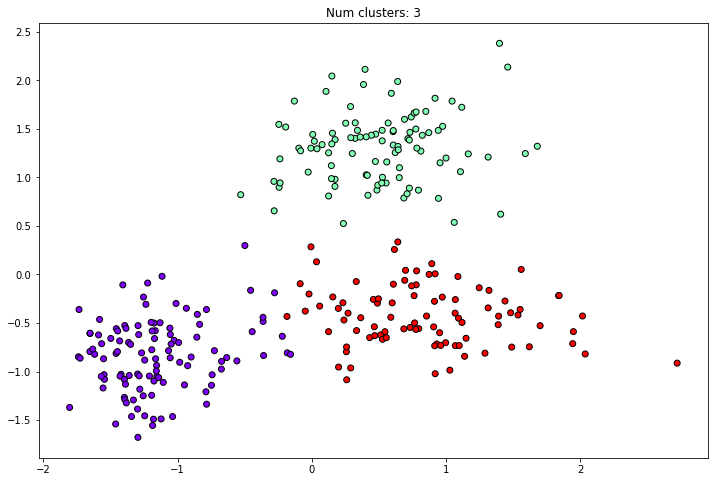

In [26]:
#-- pritando o gráfico com número de clusters definido
estimator = KMeans(n_clusters=3)
estimator.fit(X_scaled)
labels = estimator.labels_

plt.scatter(x=X_scaled[:,0],
            y=X_scaled[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(3))
plt.show()

---
## Clustering de Frete

Algumas empresas sofrem com o frete dos correios, já que o serviço dos correios além de caro, é também instável. 

Para tentar resolver esse problema, o time de Data Science foi chamado para tentar encontrar alguma alternativa. Após algumas conversas, nós levantamos a possibilidade de utilizarmos serviços de entrega independentes dos correios. Mas, o problema é que esses serviços necessitam de um volume grande de encomendas por ponto de coleta. 

Uma possível solução seria encontrar pontos de coleta que pudessem agregar pedidos de vários vendedores e enviar de uma vez só com um desses serviços alternativos. Mas, como obtemos a localização desses pontos de coleta? Podemos aplicar um algoritmo de clustering nas rotas de frete mais frequentes!

Vamos tentar analisar os dados e verificar o que conseguimos obter. O dataset a seguir contém pares de endereços de origem e destino de entregas realizadas apenas na cidade de São Paulo em um curto intervalo de tempo.

In [27]:
#-- carregando os dados
df_route = pd.read_csv('../data/route_clustering.csv', sep=';')
df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


Vamos agora formar nosso vetor de features contendo as posições geográficas das nossas rotas.

*Dica: Será que é necessário padronizar as features

In [28]:
#-- padronizando os dados TODO
X = df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']].values
X_scaled = StandardScaler().fit_transform(X)

Quantos clusters vamos utilizar? (Obs: Podemos aplicar o método do cotovelo para descobrir.)

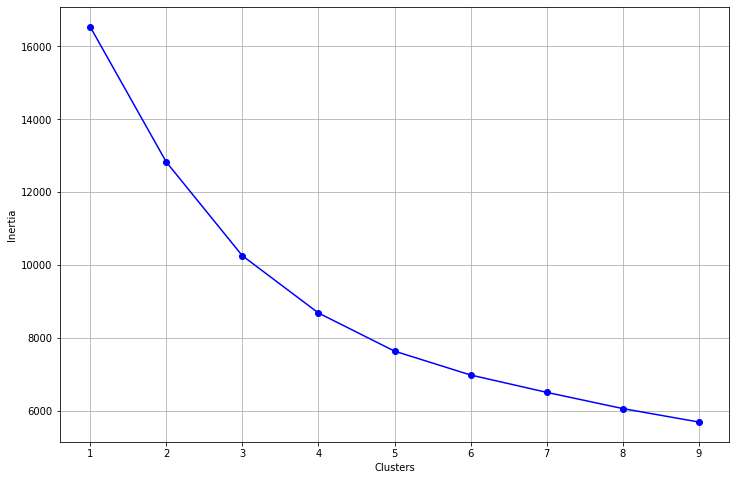

In [29]:
#-- range de valores de clusters que vamos testar
k = range(1,10,1)

#-- lista de inércias
inertias = []

#--  para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X_scaled)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Agora podemos iniciar o algoritmo de clustering.

In [34]:
#-- inicando o algoritmo
kmeans = KMeans(n_clusters=3)

In [35]:
#-- aplicando o algoritmo
labels = kmeans.fit_predict(X_scaled)

A análise da quantidade de ítens em cada cluster é sempre uma boa prática. Clusters desbalanceados são um sinal de que os dados não foram bem separados.

In [36]:
#-- verificando o balanceamento dos clusters
label, count = np.unique(labels, return_counts=True)
for l, c in zip(label,count):
    print('Cluster {}: {}'.format(l,c))

Cluster 0: 1923
Cluster 1: 1017
Cluster 2: 1196


> Existem alguamas diferenças, mas está satisfatório

Vamos ver os gráficos para analisar qualitativamente os resultados.

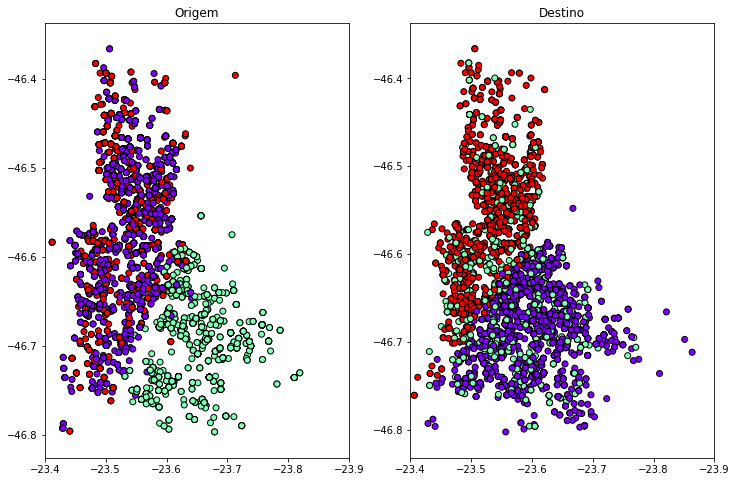

In [37]:
#-- printando o resultado
labels = kmeans.labels_

ax1 = plt.subplot(1,2,1)
ax1.set_title('Origem')
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax1.set_xlim((-23.4,-23.9))

ax2 = plt.subplot(1,2,2)
ax2.set_title('Destino')
plt.scatter(x=X[:,2],
            y=X[:,3],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax2.set_xlim((-23.4,-23.9))

plt.show()

O que achou? É possível perceber clusters bem definidos? Será que podemos utilizar esses clusters para resolver nossos problemas de frete?

### Vantagens do K-means
- Simples de entender e de ser implementado
- Eficiente
- Escalável

### Desvantagens do K-means
- Necessidade de escolher um número de clusters
- Pode sofrer com outliers
- Assume formatos esféricos para os clusters
- Funciona apenas para dados numéricos.

---
### Exemplo Prático - Kaggle NYC Taxi Trip Duration

Dados:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

![iris](https://cdn.civitatis.com/estados-unidos/nueva-york/galeria/thumbs/taxi-nueva-york.jpg)

Vamos realizar uma análise dos dados.

In [38]:
#-- carregando os dados
df_taxi = pd.read_csv('../data/nyc_trip_duration_dataset.csv')

In [39]:
#-- EDA
df_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3070488,1,2016-05-10 09:36:01,2016-05-10 09:51:36,1,-73.960396,40.773849,-73.982414,40.775364,N,935
1,id3797315,1,2016-05-30 00:29:32,2016-05-30 00:34:08,1,-73.999039,40.734386,-74.007629,40.741051,N,276
2,id2982351,1,2016-02-13 22:03:12,2016-02-13 22:13:08,2,-74.012695,40.701694,-74.011086,40.729237,N,596
3,id0576937,2,2016-05-15 00:19:30,2016-05-15 00:39:14,1,-73.950188,40.783958,-73.867882,40.845356,N,1184
4,id3672156,1,2016-01-20 08:59:47,2016-01-20 09:18:15,1,-74.001541,40.746754,-73.978409,40.750282,N,1108


Podemos utilizar diversas abordagens para analisar os dados. Vamos tentar verificar os dados de localização dos passageiros.

In [40]:
#-- selecionando os dados
df_map = df_taxi[['pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude']]
df_pick = df_map[['pickup_longitude','pickup_latitude']]
df_drop = df_map[['dropoff_longitude','dropoff_latitude']]

Vamos visualizar os dados.

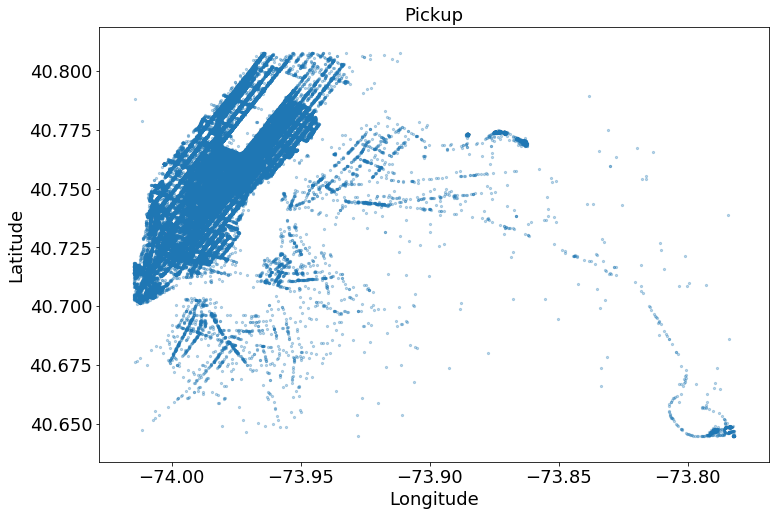

In [41]:
#-- plotando os dados
def plot_map(df, zoom=0.9):
    cutmap = zoom/100

    x = df['pickup_longitude']
    y = df['pickup_latitude']
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)
    
    x_plot = x[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)]
    y_plot = y[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)]
    plt.scatter(x=x_plot, y=y_plot, s=5, alpha=0.3)
    plt.tick_params(labelsize=18)
    plt.title('Pickup', fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)
    plt.show()

plot_map(df_taxi)

A distribuição dos dados é bem interessante. Podemos verificar que existe uma concentração grande de pontos dentro da ilha de Manhattan, o que é esperado.

Como segundo passo da análise dos dados, nós podemos tentar enriquecê-los utilizando técnicas de feature engineering e clustering. Vamos explorar o segundo em seguida.

O racional de utilizar clustering para análise exploratória e feature engineering é o fato de encontrar estruturas implícitas nos dados. Por exemplo, se tentássemos observar cada passageiro individualmente, talvez teríamos dificuldade em encontrar um padrão nos dados. Mas, é intuitivo pensar que passageiros semelhantes (mesma localização, horário etc) possam ser agrupados e tratados como um só. Assim, podemos tratar os dados por grupos controlados de passageiros, ao invés de cada indivíduo.

Vamos tentar encontrar clusters nos dados de início da corrida de taxi.

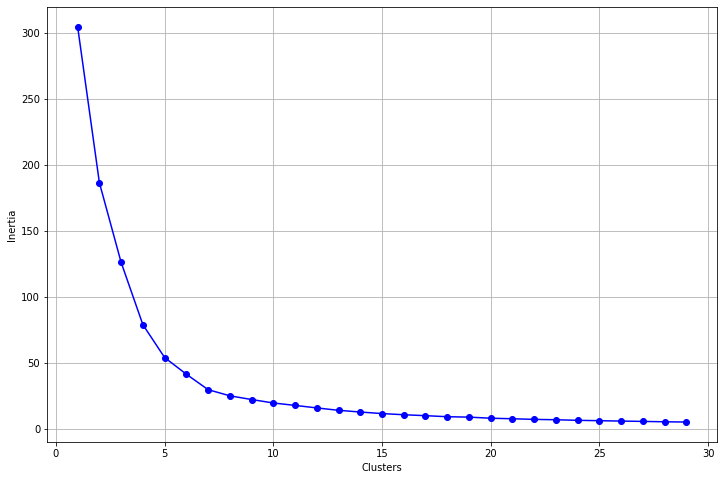

In [42]:
#-- range de valores de clusters que vamos testar
k = range(1,30,1)

#-- lista de inércias
inertias = []

#--  para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(df_pick)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [43]:
#-- carregando o algoritmo
kmeans = KMeans(n_clusters=20)

In [44]:
#-- aplicando o algortimo nos dados
X_kmeans = kmeans.fit_predict(df_pick)
df_pick['zone']  = X_kmeans

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

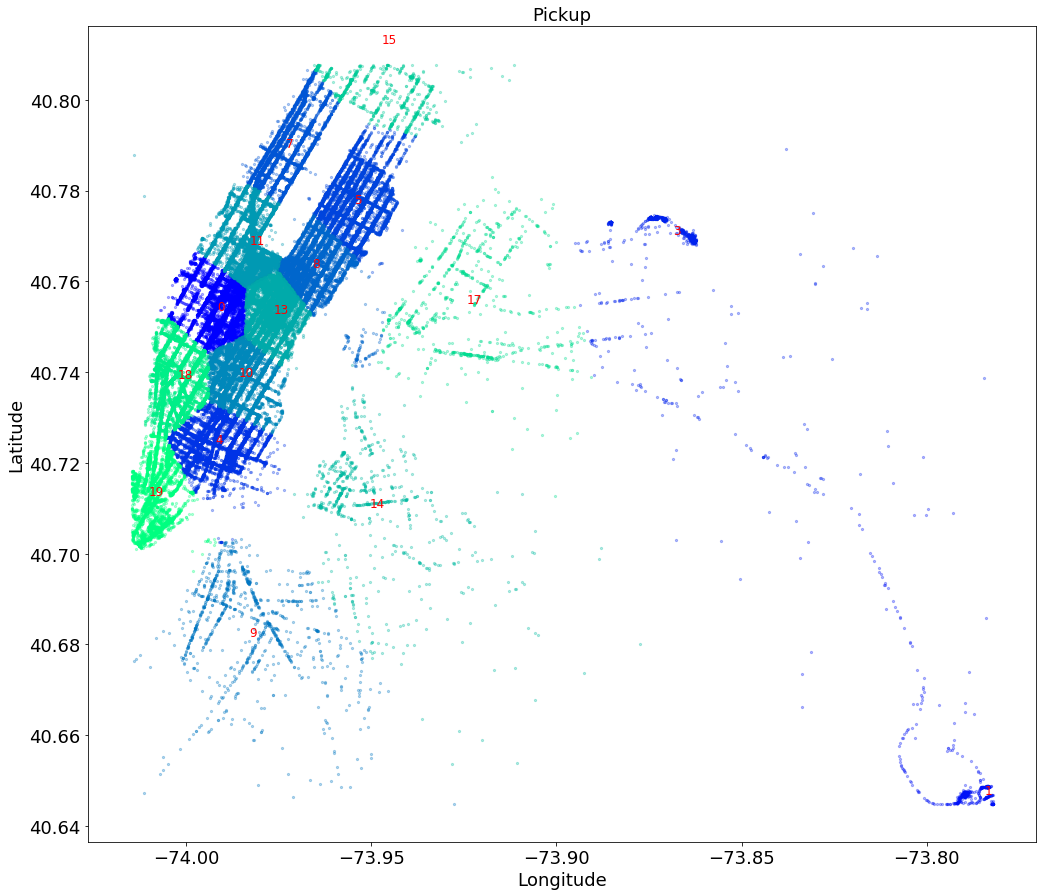

In [45]:
#-- plotando o resultado nos mapa
def draw_map_zone( df, x_name, y_name, z_name, name, zoom=0.9, cluster=None ):

    x = df[x_name]
    y = df[y_name]
    z = df[z_name]

    cutmap = zoom/100
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)
    
    zones = np.unique(z[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)])

    #cmap = plt.get_cmap('spectral') 
    cmap = plt.get_cmap('winter') 
    colors = [cmap(i) for i in np.linspace(0, 1, len(zones))]

    for i, zone in enumerate(zones):       
        plt.scatter( x=x[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     y=y[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     s=5, alpha=0.3, c=colors[i])
        if cluster:
            plt.text( cluster.cluster_centers_[zone,0], cluster.cluster_centers_[zone,1], str(zone), fontsize = 12, color='r')

    plt.tick_params(labelsize=18)
    plt.title(name, fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)


plt.figure(figsize=(17,15))
draw_map_zone(df_pick, 'pickup_longitude', 'pickup_latitude', 'zone', 'Pickup', cluster=kmeans)
plt.show()

Não por acaso, os clusters encontrados se assemelham aos bairros de Nova Iorque. Esses clusters agora podem ser utilizados de diversas formas:
- Podemos explorar a distribuição das outras features dentro de cada um dos clusters. Assim poderemos ver o quanto cada região se diferença das outras.
- Podemos também utilizar agora as labels obtidas pelo algoritmo de clustering como entrada de outros algoritmos de machine learning. Essa técnica é muito utilizada para melhorar a precisão dos algoritmos de regressão e classificação.

---
## Hierarchical Clustering

Vamos agora aprender sobre outro método de clustering: [**Hierarchical Clustering**](https://en.wikipedia.org/wiki/Hierarchical_clustering). Como o nome mesmo diz, ele utiliza o conceito de *hierarquia* para construir os clusters. Existem duas principais variações do algoritmo: aglomerativo e por divisão. O primeiro é mais usado na prática. O passo a passo do algoritmo é apresentado abaixo:

- Primeiro colocamos todos as observações em clusters próprios (individuais);
- Depois, iterativamente procuramos os clusters mais próximos\* e agrupamos eles em um novo cluster;
- Repetimos o passo anterior até formarmos um único cluster com todas as observações.

\*Obs: A definição de distância (ou similaridade) entre clusters depende do tipo de métrica de distância (Euclidiana, Manhattan, cosseno etc) e ligação (Ward, simples, completa etc).

Como podemos ver no algoritmo, o objetivo é a criação de um grande cluster que agrupe todos os dados. Nós podemos visualizar esse histórico de agrupamentos a partir de um [dendrograma](https://en.wikipedia.org/wiki/Dendrogram). A então criação de clusters mais granulares depende da região de similaridade que se deseja realizar o corte.

<tr>
    <td> <img src="../figures/fluxogramaHierarquico.png"  /> </td>
    <td> <img src="https://media.giphy.com/media/pSNCWCEAsgrAs/giphy.gif" style="width: 700px;"/> </td>
</tr>

Vamos aplicar o método de Hierarchical Clustering no dataset.

In [46]:
#-- carregando os dados
df_user = pd.read_csv('../data/user_patterns.csv', sep=';')

X = df_user.values

# Dados padronizados
X_scaled = StandardScaler().fit_transform(X)

In [47]:
#-- importando o métodos linkage (Hierarchical Clustering) e dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

O scikit-learn possui um método próprio para o algoritmo de [Hierarchical Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering). Entretanto, ele não nos permite visualizar facilmente o dendrograma final. Por isso, vamos utilizar a versão do scipy.

In [48]:
#-- escolhendo a métrica de distância:
distance = 'euclidean'
#-- tipo de ligação
linkage_type = 'ward'

#-- vamos aplicar o método linkage
Y = linkage(X_scaled, method=linkage_type, metric=distance)

Teste outros tipos de ligação e distâncias! Para verificar quais distâncias estão disponíveis, acesse esse [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist).

In [49]:
#-- verificando a dimensão
Y.shape

(299, 4)

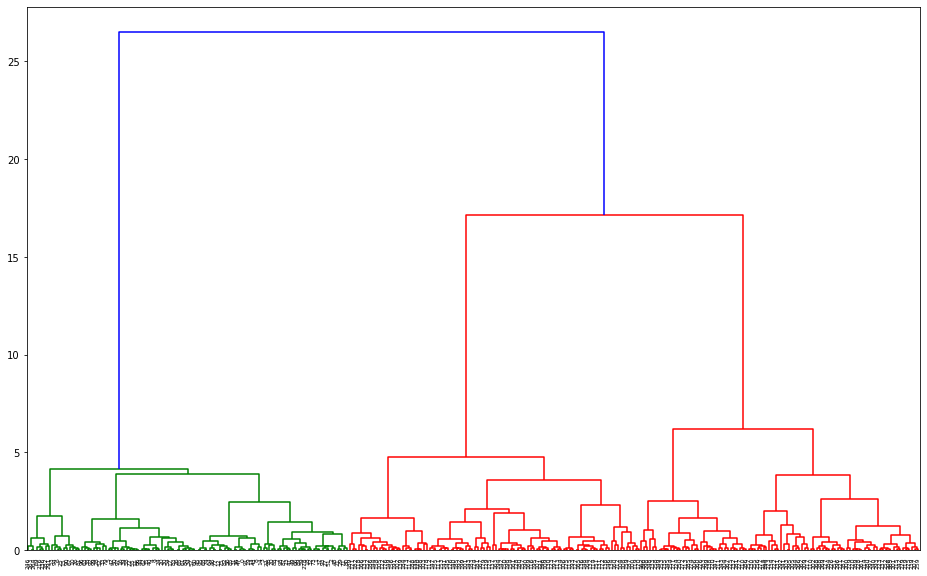

In [50]:
#-- vamos visualizar o dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

O que achou? Teste outros valores de distância e tipo de ligação para verificar as diferenças nos resultados!

O dendrograma nos permite verificar qual é o número de clusters que vamos escolher ao final. Além disso, podemos verificar se a distância e o tipo de ligação foram bem escolhidos.

O que precisamos fazer agora é escolher o número de clusters. Podemos utilizar o mesmo método do cotovelo para esse objetivo, mas, na prática, podemos apenas visualizar qual é a região que possui maior distância entre aglutinações. Outros trabalhos ainda utilizam um coeficiente de [Correlação Cofenética](https://en.wikipedia.org/wiki/Cophenetic_correlation) para encontrar uma boa posição de corte no dendrograma.

Para essa tarefa nós podemos usar o método [`fcluster`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.fcluster.html) do scipy. Ele nos permite realizar um corte na árvore de clustering gerada pelo Hierarchical Clustering.

In [51]:
#-- carregando o fcluster
from scipy.cluster.hierarchy import fcluster

In [52]:
#-- vamos gerar os rótulos para os clustes
num_clusters = 3
labels = fcluster(Y, num_clusters ,criterion='maxclust')

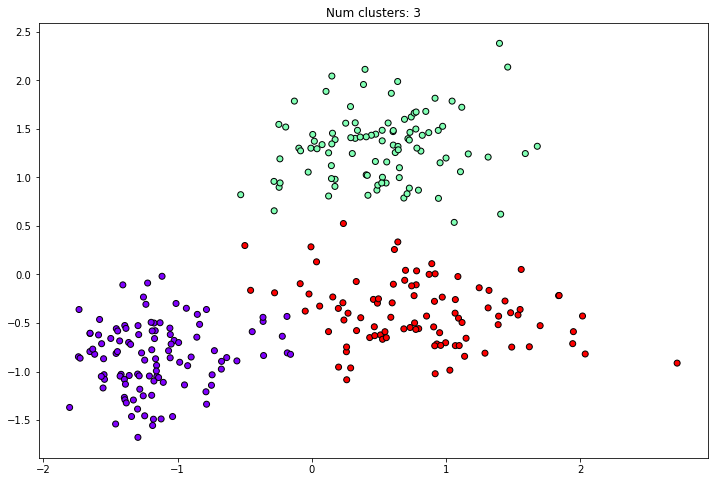

In [53]:
plt.scatter(x=X_scaled[:,0],
            y=X_scaled[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(num_clusters))
plt.show()

### Vantagens do agrupamento hierárquico
- Não precisamos escolher um número inicial de clusters
- Dendrogramas são ótimos para visualização dos clusters
- Gera uma hierarquia entre os clusters

### Desvantagens do agrupamento hierárquico
- Complexidade
- Dependendo dos dados, pode ser difícil escolher o número de clusters
- Um agrupamento feito erroneamente não pode ser desfeito

## Clustering de Frete

Vamos tentar aplicar o mesmo algoritmo para o problema de cluster de frete.

In [54]:
#-- carregando os dados
df_route = pd.read_csv('../data/route_clustering.csv', sep=';')
df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


In [55]:
#-- selecionando as features
X = df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']].values
X_scaled = StandardScaler().fit_transform(X)

In [56]:
#-- escolhendo a métrica de distância:
distance = 'euclidean'
#-- tipo de ligação
linkage_type = 'ward'

#-- vamos aplicar o método linkage
Y = linkage(X_scaled, method=linkage_type, metric=distance)

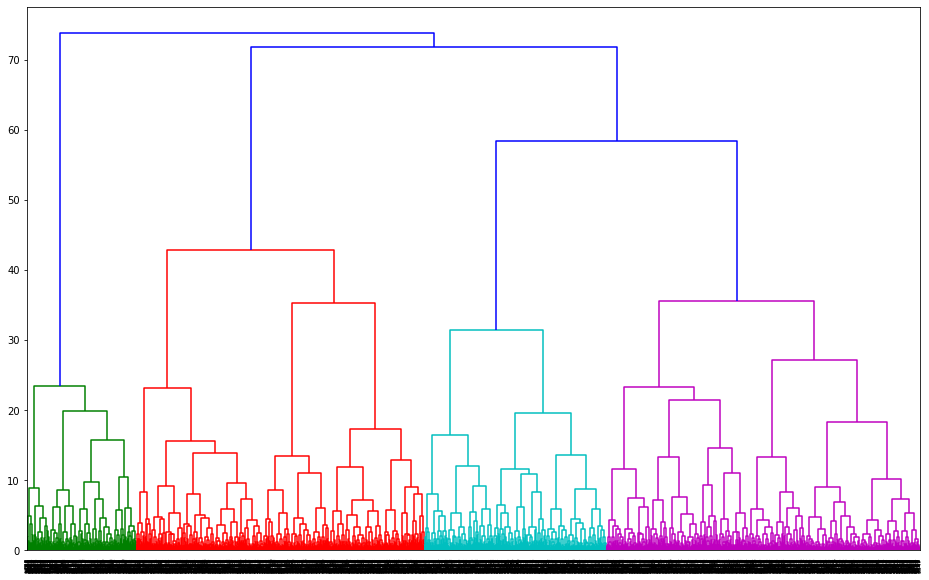

In [57]:
#-- visualizar o dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

In [58]:
#-- gerar os rótulos para os clustes
num_clusters = 4
labels = fcluster(Y, num_clusters ,criterion='maxclust')

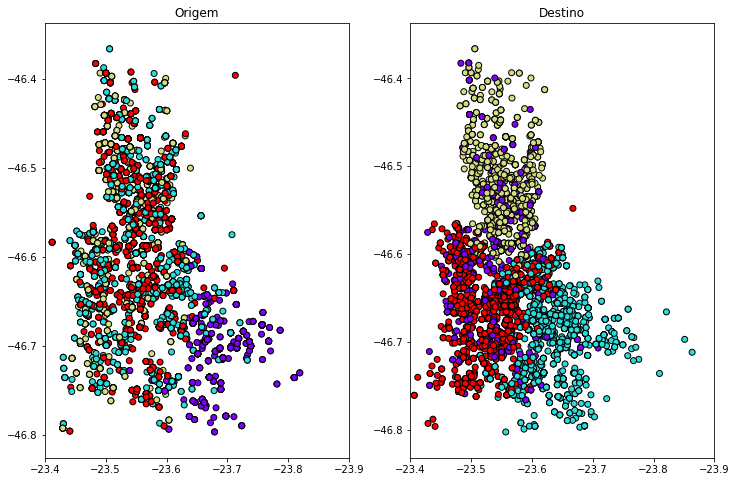

In [59]:
#-- plotando o resultado
ax1 = plt.subplot(1,2,1)
ax1.set_title('Origem')
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax1.set_xlim((-23.4,-23.9))

ax2 = plt.subplot(1,2,2)
ax2.set_title('Destino')
plt.scatter(x=X[:,2],
            y=X[:,3],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax2.set_xlim((-23.4,-23.9))

plt.show()

## DBSCAN

O DBSCAN é um método de clustering por densidade que busca por clusters definidos como regiões com alta densidade de objetos, separados por regiões de baixa densidade. 

Ele necessida dos seguintes parâmetros:

- **ɛ** : raio da vizinhança ao redor do ponto P
- **minPts**: número mínimo de pontos na vizinhança para que seja definido um cluster

Com base nesses dois parâmetros, o DBSCAN categoria os pontos em três categorias:
- **Core Points**: um ponto P é um core point se sua vizinhança contém ao menos minPts
- **Border Points**: um ponto Q é um border point se sua vizinhança contem menos pontos que minPts, mas se Q é alcancável por algum core point P.
- **Outlier**: um ponto O é um outlier se não for nem um core point e nem um border point

<tr>
    <td> <img src="../figures/fluxogramaDBSCAN.png"  /> </td>
    <td> <img src="https://media.giphy.com/media/lCL2GQewp7fkk/giphy.gif" style="width: 600px;"/> </td>
</tr>

**Outro gif ilustrando o DBSCAN:**

![](https://cdn-images-1.medium.com/max/800/1*tc8UF-h0nQqUfLC8-0uInQ.gif)

In [65]:
#-- importando os dados
df_case = pd.read_csv('../data/case.csv')
df_case.head()

,visitas,tempo
0,3,2
1,16,18
2,7,1
3,14,11
4,3,24


In [66]:
df_case_pad = StandardScaler().fit_transform(df_case)
df_case_pad

array([[-1.09550267, -1.56788656],
       [-0.57232076, -0.92736641],
       [-0.93452362, -1.60791907],
       ...,
       [-0.77354457,  0.914129  ],
       [-0.73329981,  1.99500674],
       [-0.2101179 ,  0.95416151]])

In [67]:
# TODO
# Importar o DBSCAN
from sklearn.cluster import DBSCAN

In [76]:
# TODO
# Escolha um epsilon e um minPts
dbscan = DBSCAN(eps = .1, min_samples = 8)
# salvar os clusters atribuídos para cada exemplo
clusters = dbscan.fit_predict(df_case_pad)

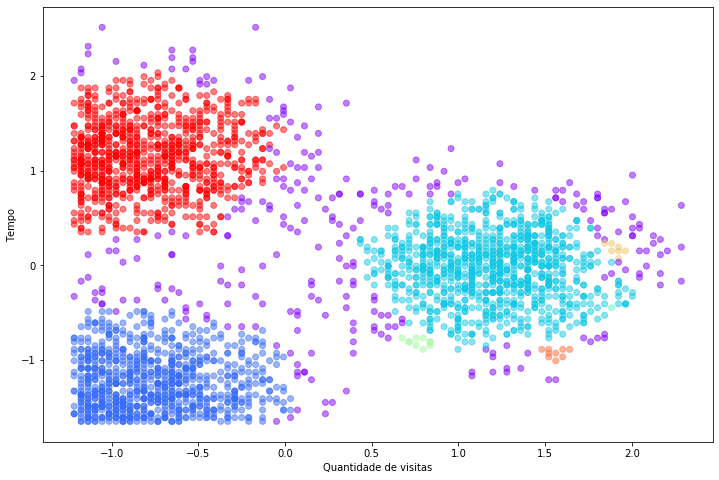

In [77]:
# plota os clusters encontrados
plt.scatter(df_case_pad[:,0], df_case_pad[:,1], c=clusters, alpha=0.5, cmap='rainbow')
plt.ylabel('Tempo')
plt.xlabel('Quantidade de visitas')
plt.show()

### Vantagens do DBSCAN
- Não é necessário especificar um número inicial de clusters
- Lida bem com outliers
- Consegue encontrar clusters com formatos diferentes

### Desvantagens do DBSCAN
- A escolha dos dois parâmetros iniciais pode não ser muito intuitiva
- Tem dificuldade para encontrar clusters se a densidade dos dados variar muito

### Exercício

In [ ]:
#-- importando os dados
df_customer = pd.read_csv('../data/customer_segmentation.csv')
df_customer.head()

In [ ]:
df_customer_dummies = pd.get_dummies(df_customer, columns=['tem_cartao'])

In [ ]:
df_customer_pad = StandardScaler().fit_transform(df_customer_dummies)
df_customer_pad

In [ ]:
# TODO
# Importar o DBSCAN
from sklearn.cluster import DBSCAN

In [ ]:
# TODO
# Escolha um epsilon e um minPts
dbscan = DBSCAN(eps = 1, min_samples = 20)
# salvar os clusters atribuídos para cada exemplo
clusters = dbscan.fit_predict(df_customer_pad)

In [ ]:
# plota os clusters encontrados
plt.scatter(df_customer_pad[:,2], df_customer_pad[:,3], c=clusters, alpha=0.5, cmap='rainbow')
plt.xlabel('Tempo')
plt.ylabel('Quantidade de visitas')
plt.show()

### Outros métodos de clustering

**Por partição**
- K-medians
- [K-modes](https://github.com/nicodv/kmodes)
- K-prototypes

**Por densidade/ hierárquico**
- [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) 

**Por distribuição**
- Gaussian Mixture Models (GMMs)

**Redes neurais**
- Self Organizing Map (SOM)

O [sklearn](https://scikit-learn.org/stable/modules/clustering.html) conta com mais alguns algoritmos de clustering e também tem uma comparação entre eles para vários conjuntos de dados:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)